In [1]:
import numpy as np
from nptyping import NDArray
import random
import numpy.linalg as LA
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple, Optional, Any, Callable
from PIL import Image
import os
import json

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from utils import load_image_to_arr, display_rgb, SVD2D
import dim_reduction
from spectral_data import ImageSpectralData
dim_reduction.init_basis_cache()
import cityscapes_helper
from dataset_creation import (
    MultiScaleImageSampler, 
    ImageChunkSummarizerOptions, 
    MultiScaleImageEncoder, 
    MultiScaleImageDecoder,
    MultiScaleMultiResolutionImageSampler,
    DownsampledImageAtScale,
    ImageAtScale, 
    CityscapesDatasetFactory, 
    WholeImage,
    CityScapesDataset,
    semantic_image_composition
)
from image_segmentation import (
    semantic_composition_grid,
    feature_grid,
    predict_semantic_grid
)
from cityscapes_helper import format_semantic_composition

In [3]:
# Ben Desptop
#cityscapes_helper.set_visual_data_zip_path("C:\\Users\\Ben\\Downloads\\leftImg8bit_trainvaltest.zip")
#cityscapes_helper.set_semantic_data_zip_path("C:\\Users\\Ben\\Downloads\\gtFine_trainvaltest.zip")

#Ben Laptop (via WSL)
cityscapes_helper.set_visual_data_zip_path("/mnt/c/Users/benki/Downloads/leftImg8bit_trainvaltest.zip")
cityscapes_helper.set_semantic_data_zip_path("/mnt/c/Users/benki/Downloads/gtFine_trainvaltest.zip")

cityscapes_helper.initialize_tool()

In [4]:
scales = [240, 96, 32]

whole_img_options = ImageChunkSummarizerOptions()
whole_img_options.downsample_factor = 8
whole_img_options.n_pcm_coeffs = [80, 40, 30]

opt_240 = ImageChunkSummarizerOptions()
opt_240.downsample_factor = 3
opt_240.n_pcm_coeffs = [120, 40, 20]

opt_96 = ImageChunkSummarizerOptions()
opt_96.downsample_factor = 2
opt_96.n_pcm_coeffs = [120, 40, 20]

opt_32 = ImageChunkSummarizerOptions()
opt_32.downsample_factor = 1
opt_32.n_pcm_coeffs = [60, 20, 15]

chunk_summarizer_options = [whole_img_options, opt_240, opt_96, opt_32]
downsample_factors = [3, 2, 1]

multiscaleEncoder = MultiScaleImageEncoder(chunk_summarizer_options)

cologne_000100


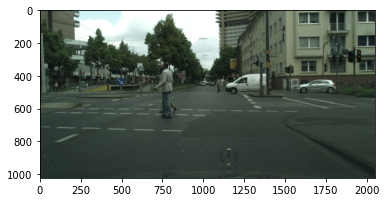

In [5]:
#(scene_id, (vis, sem)) = cityscapes_helper.loadRandomScene()
scene_id = "cologne_000100"
vis = cityscapes_helper.loadVisualInfo(scene_id)
print(scene_id)
display_rgb(vis)

(24, 56, 30)


Text(0.5, 1.0, 'Building')

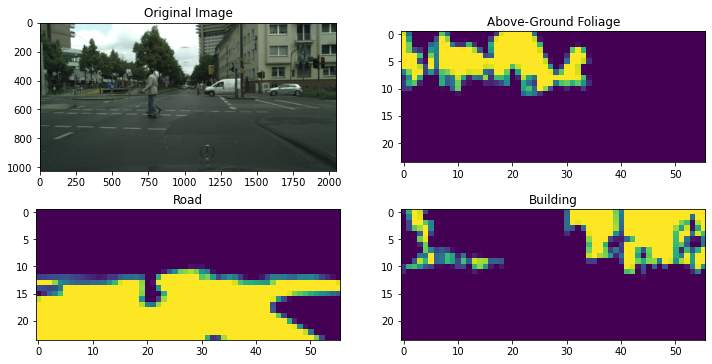

In [6]:
cologne_semantic_grid = semantic_composition_grid(scene_id, scales)
print(cologne_semantic_grid.shape)

class_index = 21 #above-ground folliage
true_foliage_semantic_map = cologne_semantic_grid[:, :, class_index]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))
ax1.imshow(vis)
ax1.set_title("Original Image")
ax2.imshow(cologne_semantic_grid[:, :, 21])
ax2.set_title("Above-Ground Foliage")
ax3.imshow(cologne_semantic_grid[:, :, 7])
ax3.set_title("Road")
ax4.imshow(cologne_semantic_grid[:, :, 11])
ax4.set_title("Building")


In [7]:
cologne_feature_grid = feature_grid(scene_id, multiscaleEncoder, scales, downsample_factors)
cologne_feature_grid.shape

(24, 56, 701)

0.npy,1.npy,2.npy,3.npy,4.npy,5.npy,6.npy,


array([104., 104.])

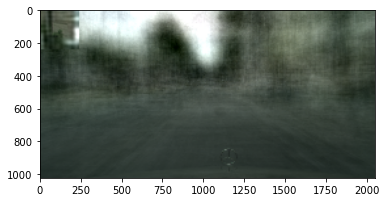

In [8]:
dataset = CityScapesDataset("full_dataset_v1_30000")
dataset.load()
img = dataset.decoder.decode(cologne_feature_grid[0, 0, :])
fig, ax = plt.subplots()
ax.imshow(img)
f = cologne_feature_grid[0, 0, :]
f_scale = f[dataset.scale_masks[3]]
anchor_mask = dataset.feature_masks[3]["anchor"]

f_scale[anchor_mask]


In [9]:
import matplotlib.patches as patches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def getAnchor(feature, scale_index, dataset):
    f_scale = feature[dataset.scale_masks[scale_index]]
    anchor_mask = dataset.feature_masks[scale_index]["anchor"]
    return f_scale[anchor_mask]

def generateDemoFrame_FullRes(feature_grid, semantic_grid, r, c, full_res, dataset):
    fig, ax = plt.subplots(dpi=300)
    plt.figure(dpi=600)
    
    semantic_composition = semantic_grid[r, c, :]
    feature = feature_grid[r, c, :]

    ax.imshow(full_res)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    rect1 = patches.Rectangle(getAnchor(feature, 1, dataset), 240, 240, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(rect1)
    rect2 = patches.Rectangle(getAnchor(feature, 2, dataset), 96, 96, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect2)
    rect3 = patches.Rectangle(getAnchor(feature, 3, dataset), 32, 32, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect3)

    sem_ax = fig.add_axes([.7, .225, .55, .55], facecolor='k')
    sem_ax.get_xaxis().set_visible(False)
    sem_ax.get_yaxis().set_visible(False)
    sem_ax.imshow(np.array([semantic_composition]).T)

    canvas = FigureCanvas(fig)
    canvas.draw()       # draw the canvas, cache the renderer

    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image




def generateDemoFrame_Encoded(feature_grid, semantic_grid, r, c, dataset):
    fig, ax = plt.subplots(dpi=300)
    plt.figure(dpi=300)

    semantic_composition = semantic_grid[r, c, :]
    feature = feature_grid[r, c, :]

    ax.imshow(dataset.decoder.decode(feature))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    rect1 = patches.Rectangle(getAnchor(feature, 1, dataset), 240, 240, linewidth=1, edgecolor='k', facecolor='none', alpha=0.35)
    ax.add_patch(rect1)
    rect2 = patches.Rectangle(getAnchor(feature, 2, dataset), 96, 96, linewidth=1, edgecolor='b', facecolor='none', alpha=0.35)
    ax.add_patch(rect2)
    rect3 = patches.Rectangle(getAnchor(feature, 3, dataset), 32, 32, linewidth=1, edgecolor='r', facecolor='none', alpha=0.35)
    ax.add_patch(rect3)

    sem_ax = fig.add_axes([.7, .225, .55, .55], facecolor='k')
    sem_ax.get_xaxis().set_visible(False)
    sem_ax.get_yaxis().set_visible(False)
    sem_ax.imshow(np.array([semantic_composition]).T)

    canvas = FigureCanvas(fig)
    canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image

#generateDemoFrame(cologne_feature_grid, cologne_semantic_grid, 0, 0, dataset.decoder)
[240, 96, 32]
#generateDemoFrame_FullRes(cologne_feature_grid, cologne_semantic_grid, 13, 23, vis, dataset)
generateDemoFrame_Encoded(cologne_feature_grid, cologne_semantic_grid, 10, 10, dataset)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

<Figure size 1800x1200 with 0 Axes>

In [10]:
def generateFullResAnimation(feature_grid, semantic_grid, full_res, dataset):
    frames = []
    for r in range(5, 9):
        for c in range(56):
            newFrame = generateDemoFrame_FullRes(feature_grid, semantic_grid, r, c, full_res, dataset)
            frames.append(newFrame)
            plt.close()
        print(r)
    return frames

full_res_animation = generateFullResAnimation(cologne_feature_grid, cologne_semantic_grid, vis, dataset)

5
6
7
8


In [11]:
animframes_as_im = [Image.fromarray(I) for I in full_res_animation]
animframes_as_im[0].save('fullresAnim.gif',save_all=True, append_images=animframes_as_im[1:], optimize=False, loop=0)

In [10]:
def generateEncodedAnimation(feature_grid, semantic_grid, dataset):
    frames = []
    for r in range(5, 9):
        for c in range(56):
            newFrame = generateDemoFrame_Encoded(feature_grid, semantic_grid, r, c, dataset)
            frames.append(newFrame)
            plt.close()
        print(r)
    return frames

encoded_res_animation = generateEncodedAnimation(cologne_feature_grid, cologne_semantic_grid, dataset)

5
6
7
8


In [11]:
animframes_as_im = [Image.fromarray(I) for I in encoded_res_animation]
animframes_as_im[0].save('encodedAnim.gif',save_all=True, append_images=animframes_as_im[1:], optimize=False, loop=0)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

dataset = CityScapesDataset("full_dataset_v1_30000")
dataset.load()

#Select the mean color of the smallest/core chunk
toy_feature_subset = [(3, 'mean')]
toy_feature_mask = dataset.get_feature_subset_mask(toy_feature_subset)
tiny_features = dataset.features[:, toy_feature_mask]
tiny_features_normalized = dataset.get_normalized_features()[:, toy_feature_mask]
print(tiny_features_normalized.shape)

#figure out which ones are mostly foliage
foliage_index = 21
foliage_composition = dataset.labels[:, foliage_index]
majority_foliage_mask = foliage_composition > 0.5

folliage_nn_classifier = KNeighborsClassifier(3).fit(tiny_features_normalized, majority_foliage_mask)

def folage_nn_prediction_function(normalized_feature: NDArray[Any]):
    toy_feature = normalized_feature[toy_feature_mask]
    pred_is_foliage = folliage_nn_classifier.predict(toy_feature.reshape(1, -1))[0]
    result = np.zeros(30)
    if(pred_is_foliage):
        result[21] = 1.0
    return result



0.npy,1.npy,2.npy,3.npy,4.npy,5.npy,6.npy,
(30000, 3)


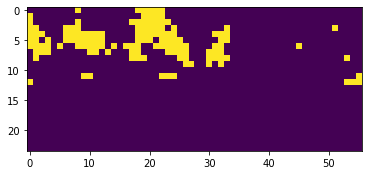

In [10]:
R = predict_semantic_grid(cologne_feature_grid, dataset, True, folage_nn_prediction_function)
foliage_semantic_map = R[:, :, 21]
fig, ax = plt.subplots()
ax.imshow(foliage_semantic_map)

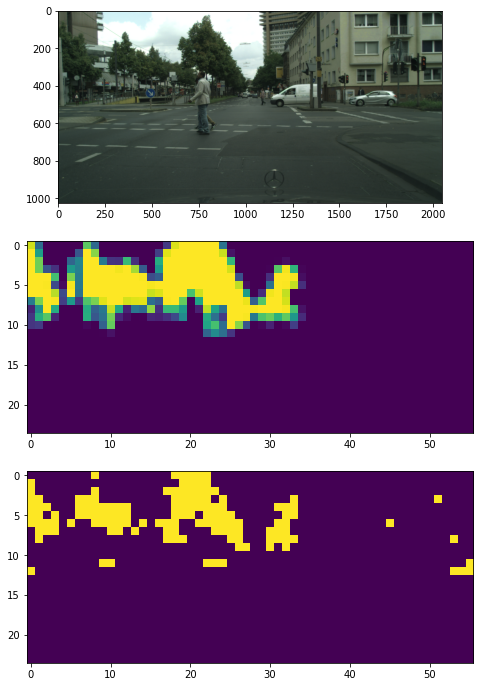

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
ax1.imshow(vis)
ax2.imshow(true_foliage_semantic_map)
ax3.imshow(foliage_semantic_map)